In [19]:
import os
import re
import csv
import shutil
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Constraints

In [ ]:
# constraints
dataset_dir = "Humans"
processed_data_dir = "processed_data"
image_size = (64, 64)
test_size = 0.2
random_state = 42
num_eigenfaces = 200
knn_k = 3

num_images = len([file for file in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, file))])
print("Nums of Images in Dataset:", num_images)

Nums of Images in Dataset: 7219


Create Folder: images and labels

In [23]:
os.makedirs(processed_data_dir, exist_ok=True)
images_folder = os.path.join(processed_data_dir, "images")
labels_folder = os.path.join(processed_data_dir, "labels")
os.makedirs(images_folder, exist_ok=True)
os.makedirs(labels_folder, exist_ok=True)

In [26]:
def parse_label_from_filename(fname):
    m = re.match(r"(\d+)", fname)
    if m:
        return int(m.group(1))
    return -1

all_files = sorted([file for file in os.listdir(dataset_dir) if file.lower().endswith(('.jpg','.jpeg','.png'))])
if len(all_files) == 0:
    raise SystemExit(f"No images found in {dataset_dir}")

labels_csv_path = os.path.join(labels_folder, "labels.csv")
with open(labels_csv_path, mode="w", newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "label"])
    for filename in all_files:
        label = parse_label_from_filename(filename)
        src = os.path.join(dataset_dir, filename)
        dst = os.path.join(images_folder, filename)
        shutil.copy2(src, dst)   # copy image to images_folder
        writer.writerow([filename, label])
print(f"Copied {len(all_files)} images to {images_folder} and wrote labels to {labels_csv_path}")

Copied 7219 images to processed_data\images and wrote labels to processed_data\labels\labels.csv


Load Images into Memory (flatten -> X-matrix), load labels from csv

In [27]:
def load_images_and_labels(images_folder, labels_csv, img_size=(64,64), drop_unknown=False):
    X_list = []
    y_list = []
    filenames = []
    # read labels
    label_map = {}
    with open(labels_csv, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            label_map[row['filename']] = int(row['label'])

    for fname in sorted(os.listdir(images_folder)):
        if not fname.lower().endswith(('.jpg','.jpeg','.png')):
            continue
        label = label_map.get(fname, -1)
        if drop_unknown and label == -1:
            continue
        path = os.path.join(images_folder, fname)
        try:
            img = Image.open(path).convert('L').resize(img_size, Image.BILINEAR)
            arr = np.asarray(img, dtype=np.float32).ravel() / 255.0   # normalize [0,1]
            X_list.append(arr)
            y_list.append(label)
            filenames.append(fname)
        except Exception as e:
            print(f"Skipping {fname}: {e}")

    X = np.stack(X_list)
    y = np.array(y_list)
    return X, y, filenames

X, y, fnames = load_images_and_labels(images_folder, labels_csv_path, img_size=image_size, drop_unknown=False)
print(f"Loaded X shape: {X.shape}, y shape: {y.shape}, unique labels: {np.unique(y)[:10]} ...")

c:\Users\TUAN NGOC\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loaded X shape: (7219, 4096), y shape: (7219,), unique labels: [1] ...


In [28]:
num_unknown = np.sum(y == -1)
print(f"Number of unknown label entries: {num_unknown}")
if num_unknown > 0:
    # choose to drop them (you can also keep but they'd be a single class)
    mask = (y != -1)
    X = X[mask]
    y = y[mask]
    fnames = [f for i,f in enumerate(fnames) if mask[i]]
    print(f"Dropped unknowns. New X shape: {X.shape}")

Number of unknown label entries: 0


In [29]:
unique_labels = sorted(list(set(y.tolist())))
label_to_idx = {lab: idx for idx, lab in enumerate(unique_labels)}
y_idx = np.array([label_to_idx[lab] for lab in y])
print(f"Number of classes after mapping: {len(unique_labels)}")

Number of classes after mapping: 1


In [30]:
if len(unique_labels) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_idx, test_size=test_size, random_state=random_state, stratify=y_idx
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_idx, test_size=test_size, random_state=random_state
    )
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (5775, 4096), Test shape: (1444, 4096)


In [31]:
mean_face = np.mean(X_train, axis=0)             # shape (d,)
X_train_centered = X_train - mean_face          # (N_train, d)
X_test_centered = X_test - mean_face

In [32]:
A = X_train_centered
N_train, d = A.shape
print(f"A shape: {A.shape}. Computing C_small (N x N) ...")
C_small = (A @ A.T) / N_train

A shape: (5775, 4096). Computing C_small (N x N) ...


In [34]:
print("Performing eigen-decomposition of C_small ...")
eigen_values_small, eigen_vectors_small = np.linalg.eigh(C_small)

Performing eigen-decomposition of C_small ...


In [37]:
# sort descending
idx = np.argsort(eigen_values_small)[::-1]
eigen_values_small = eigen_values_small[idx]
eigen_vectors_small = eigen_vectors_small[:, idx]

# map eigenvectors to original high-dimensional space
print("Mapping small-space eigenvectors -> eigenfaces in original space ...")
eigen_vectors = A.T @ eigen_vectors_small    # shape (d, N_train)

# normalize each eigenface (column)
eps = 1e-12
norms = np.linalg.norm(eigen_vectors, axis=0, keepdims=True)
eigen_vectors = eigen_vectors / (norms + eps)

# filter non-zero eigenvalues (numerical)
valid_mask = eigen_values_small > 1e-8
eigen_values = eigen_values_small[valid_mask]
eigen_faces_all = eigen_vectors[:, valid_mask]
print(f"Found {eigen_faces_all.shape[1]} valid eigenfaces (non-zero eigenvalues).")

Mapping small-space eigenvectors -> eigenfaces in original space ...
Found 3064 valid eigenfaces (non-zero eigenvalues).


In [38]:
k = min(num_eigenfaces, eigen_faces_all.shape[1])
eigen_faces = eigen_faces_all[:, :k]     # shape (d, k)
eigenvalues = eigen_values[:k]
explained = np.sum(eigenvalues) / np.sum(eigen_values)
print(f"Chose k={k} eigenfaces. Fraction of variance in selected comps: {explained*100:.2f}%")

Chose k=200 eigenfaces. Fraction of variance in selected comps: 95.99%


In [39]:
# 9) Project data into eigenface space (feature extraction)
#    projection = X_centered @ eigenfaces  -> (N, k)
# -----------------------------
X_train_project = X_train_centered @ eigen_faces   # (N_train, k)
X_test_project = X_test_centered @ eigen_faces     # (N_test, k)
print(f"Projected train/test into k-dim feature space: {X_train_project.shape}, {X_test_project.shape}")

Projected train/test into k-dim feature space: (5775, 200), (1444, 200)


In [40]:
# 10) KNN from scratch (Euclidean + majority vote)
# -----------------------------
def knn_predict_one(test_vector, train_project, train_labels, k=3):
    dists = np.linalg.norm(train_project - test_vector, axis=1)
    nearest_idx = np.argsort(dists)[:k]
    nearest_labels = train_labels[nearest_idx]
    vals, counts = np.unique(nearest_labels, return_counts=True)
    return vals[np.argmax(counts)]

def knn_predict_batch(test_project, train_project, train_labels, k=3):
    preds = []
    for test_vector in test_project:
        preds.append(knn_predict_one(test_vector, train_project, train_labels, k=k))
    return np.array(preds)


In [45]:
print("Running KNN classification...")
y_pred = knn_predict_batch(X_test_project, X_train_project, y_train, k=knn_k)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy (Eigenfaces + KNN): {accuracy:.2f}")

Running KNN classification...
Accuracy (Eigenfaces + KNN): 1.00


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

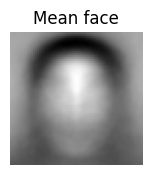

In [46]:
# 11) Plot Mean Face and some eigenfaces, and show original vs reconstructed for a sample test image
# -----------------------------
d = image_size[0]
plt.figure(figsize=(12,4))
plt.subplot(1, 6, 1)
plt.imshow(mean_face.reshape(image_size), cmap='gray')
plt.title("Mean face")
plt.axis('off')

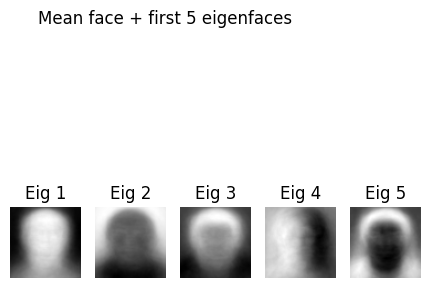

In [47]:
# show first 5 eigenfaces
for i in range(5):
    if i >= eigen_faces.shape[1]:
        break
    plt.subplot(1, 6, i+2)
    plt.imshow(eigen_faces[:, i].reshape(image_size), cmap='gray')
    plt.title(f"Eig {i+1}")
    plt.axis('off')
plt.suptitle("Mean face + first 5 eigenfaces")
plt.show()

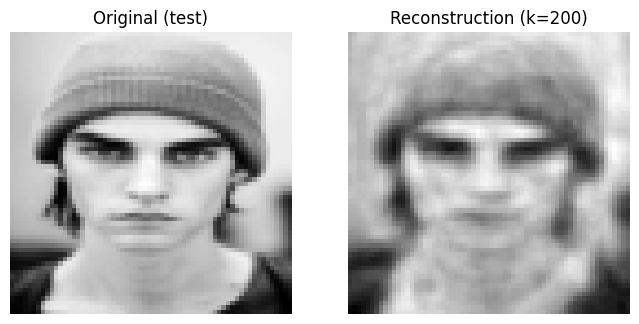

In [48]:
# reconstruction example: choose one test index
test_idx = 0
proj_vec = X_test_project[test_idx]
recon = mean_face + eigen_faces @ proj_vec   # (d,)
orig = X_test[test_idx]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig.reshape(image_size), cmap='gray')
plt.title("Original (test)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(recon.reshape(image_size), cmap='gray')
plt.title(f"Reconstruction (k={k})")
plt.axis('off')
plt.show()

In [49]:
# 12) Save results (optional)
# -----------------------------
np.savez_compressed(os.path.join(processed_data_dir, "eigenfaces_pipeline.npz"),
                    mean_face=mean_face, eigenfaces=eigen_faces, eigenvalues=eigenvalues,
                    X_train_project=X_train_project, X_test_project=X_test_project,
                    y_train=y_train, y_test=y_test, label_map=unique_labels)
print(f"Saved pipeline outputs to {processed_data_dir}/eigenfaces_pipeline.npz")


Saved pipeline outputs to processed_data/eigenfaces_pipeline.npz
